In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import matplotlib
import pickle
try:
    from fastprogress.fastprogress import progress_bar as tqdm
except:
    from tqdm import tqdm

confirmed_cases_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
confirmed_cases = pd.read_csv(confirmed_cases_url, sep=',')
deaths_url =  'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
deaths = pd.read_csv(deaths_url, sep=',')
path_to_save = '../../figures/'
path_data = '../../data/'

In [2]:
def delay_cases(new_I_t, len_new_I_t, len_new_cases_obs , delay, delay_arr):
    """
    Delays the input new_I_t by delay and return and array with length len_new_cases_obs
    The initial delay of the output is set by delay_arr. 
    
    Take care that delay is smaller or equal than delay_arr, otherwise zeros are 
    returned, which could potentially lead to errors

    Also assure that len_new_I_t is larger then len(new_cases_obs)-delay, otherwise it 
    means that the simulated data is not long enough to be fitted to the data.
    """
    delay_mat = make_delay_matrix(n_rows=len_new_I_t, 
                                  n_columns=len_new_cases_obs, initial_delay=delay_arr)
    inferred_cases = interpolate(new_I_t, delay, delay_mat)
    return inferred_cases 

def make_delay_matrix(n_rows, n_columns, initial_delay=0):
    """
    Has in each entry the delay between the input with size n_rows and the output
    with size n_columns
    """
    size = max(n_rows, n_columns)
    mat = np.zeros((size, size))
    for i in range(size):
        diagonal = np.ones(size-i)*(initial_delay + i)
        mat += np.diag(diagonal, i)
    for i in range(1, size):
        diagonal = np.ones(size-i)*(initial_delay - i)
        mat += np.diag(diagonal, -i)
    return mat[:n_rows, :n_columns]

def interpolate(array, delay, delay_matrix):
    interp_matrix = tt.maximum(1-tt.abs_(delay_matrix - delay), 0)
    interpolation = tt.dot(array,interp_matrix)
    return interpolation

In [3]:
import pymc3 as pm
import theano.tensor as tt
import theano
import datetime
import time

date_data_begin = datetime.date(2020,3,1)
date_data_end = datetime.date(2020,3,15)
num_days_to_predict = 28


diff_data_sim = 16 # should be significantly larger than the expected delay, in 
                   # order to always fit the same number of data points.
date_begin_sim = date_data_begin - datetime.timedelta(days = diff_data_sim)
format_date = lambda date_py: '{}/{}/{}'.format(date_py.month, date_py.day,
                                                 str(date_py.year)[2:4])
date_formatted_begin = format_date(date_data_begin)
date_formatted_end = format_date(date_data_end)

cases_obs =  np.array(
    confirmed_cases.loc[confirmed_cases["Country/Region"] == "Germany", 
                        date_formatted_begin:date_formatted_end])[0]
#cases_obs = np.concatenate([np.nan*np.ones(diff_data_sim), cases_obs])
print('Cases yesterday ({}): {} and '
      'day before yesterday: {}'.format(date_data_end.isoformat(), *cases_obs[:-3:-1]))
num_days = (date_data_end - date_begin_sim).days
date_today = date_data_end + datetime.timedelta(days=1)
# ------------------------------------------------------------------------------ #
# model setup and training
# ------------------------------------------------------------------------------ #
np.random.seed(0)

def SIR_model(λ, μ, S_begin, I_begin, N):
    new_I_0 = tt.zeros_like(I_begin)
    def next_day(λ, S_t, I_t, _):
        new_I_t = λ/N*I_t*S_t
        S_t = S_t - new_I_t
        I_t = I_t + new_I_t - μ * I_t
        return S_t, I_t, new_I_t
    outputs , _  = theano.scan(fn=next_day, sequences=[λ], 
                               outputs_info=[S_begin, I_begin, new_I_0])
    S_all, I_all, new_I_all = outputs
    return S_all, I_all, new_I_all

with pm.Model() as model:
    # true cases at begin of loaded data but we do not know the real number
    I_begin = pm.HalfCauchy('I_begin', beta=100)

    # fraction of people that are newly infected each day
    λ = pm.Lognormal("λ", mu=np.log(0.4), sigma=0.5)

    # fraction of people that recover each day, recovery rate mu
    μ = pm.Lognormal('μ', mu=np.log(1/8), sigma=0.2)

    # delay in days between contracting the disease and being recorded
    delay = pm.Lognormal("delay", mu=np.log(8), sigma=0.2)

    # prior of the error of observed cases
    σ_obs = pm.HalfCauchy("σ_obs", beta=10)

    N_germany = 83e6

    # -------------------------------------------------------------------------- #
    # training the model with loaded data
    # -------------------------------------------------------------------------- #

    S_begin = N_germany - I_begin
    S_past, I_past, new_I_past = SIR_model(λ=λ * tt.ones(num_days-1), μ=μ, 
                                               S_begin=S_begin, I_begin=I_begin,
                                               N=N_germany)
    new_cases_obs = np.diff(cases_obs)
    new_cases_inferred = delay_cases(new_I_past, len_new_I_t=num_days - 1, 
                                     len_new_cases_obs=len(new_cases_obs), 
                                     delay=delay, delay_arr=diff_data_sim)

    # Approximates Poisson
    # calculate the likelihood of the model:
    # observed cases are distributed following studentT around the model
    pm.StudentT(
        "obs",
        nu=4,
        mu=new_cases_inferred,
        sigma=(new_cases_inferred)**0.5 * σ_obs,
        observed=new_cases_obs)  
    
    S_past = pm.Deterministic('S_past', S_past)
    I_past = pm.Deterministic('I_past', I_past)
    new_I_past = pm.Deterministic('new_I_past', new_I_past)
    new_cases_past = pm.Deterministic('new_cases_past', new_cases_inferred)
    

    # -------------------------------------------------------------------------- #
    # run model, pm trains and predicts when calling this
    # -------------------------------------------------------------------------- #
    
    time_beg = time.time()
    trace = pm.sample(draws=3000, tune=2000, chains=4)
    print("Model run in {:.2f} s".format(time.time() - time_beg))

Cases yesterday (2020-03-15): 5795 and day before yesterday: 4585


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ_obs, delay, μ, λ, I_begin]
Sampling 4 chains, 44 divergences: 100%|██████████| 20000/20000 [01:37<00:00, 205.86draws/s]
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.


Model run in 113.55 s


In [4]:
with pm.Model() as model_flat:
    # true cases at begin of loaded data but we do not know the real number
    I_begin = pm.Flat('I_begin')

    # fraction of people that are newly infected each day
    λ = pm.Flat("λ")

    # fraction of people that recover each day, recovery rate mu
    μ = pm.Flat('μ')

    # delay in days between contracting the disease and being recorded
    delay = pm.Flat("delay")

    # prior of the error of observed cases
    σ_obs = pm.Flat("σ_obs")

    N_germany = 83e6

    # -------------------------------------------------------------------------- #
    # training the model with loaded data
    # -------------------------------------------------------------------------- #

    S_begin = N_germany - I_begin
    S_past, I_past, new_I_past = SIR_model(λ=λ * tt.ones(num_days-1), μ=μ, 
                                               S_begin=S_begin, I_begin=I_begin,
                                               N=N_germany)
    new_cases_obs = np.diff(cases_obs)
    new_cases_inferred = delay_cases(new_I_past, len_new_I_t=num_days - 1, 
                                     len_new_cases_obs=len(new_cases_obs), 
                                     delay=delay, delay_arr=diff_data_sim)

    # Approximates Poisson
    # calculate the likelihood of the model:
    # observed cases are distributed following studentT around the model
    pm.StudentT(
        "obs",
        nu=4,
        mu=new_cases_inferred,
        sigma=(new_cases_inferred)**0.5 * σ_obs,
        observed=new_cases_obs)  
    
    S_past = pm.Deterministic('S_past', S_past)
    I_past = pm.Deterministic('I_past', I_past)
    new_I_past = pm.Deterministic('new_I_past', new_I_past)
    new_cases_past = pm.Deterministic('new_cases_past', new_cases_inferred)
    

    # -------------------------------------------------------------------------- #
    # run model, pm trains and predicts when calling this
    # -------------------------------------------------------------------------- #
    

In [5]:
# brute force search, create log like matrix

load_from_file = True


import pickle

from itertools import product
from tqdm.notebook import tqdm
fn = model.fn(model.logpt)

print(model.vars)


I_begin_r = np.linspace(np.log(5), np.log(100), 30)
lambda_r = np.linspace(np.log(0.1), np.log(0.6), 40)
mu_r = np.linspace(np.log(1 / 15), np.log(1 / 4), 30)
delay_r = np.linspace(np.log(5), np.log(15), 30)
sigma_obs_r = np.linspace(np.log(1), np.log(50), 20)


if not load_from_file:
    logp = []
    for values in tqdm(product(I_begin_r, lambda_r, mu_r, delay_r, sigma_obs_r), total = 30*40*30*30*20):
        point = {"I_begin_log__" : values[0], "λ_log__": values[1], "μ_log__": values[2], 
                            "delay_log__": values[3], "σ_obs_log__": values[4]}
        logp.append(fn(point))
    logp_mat = np.array(logp).reshape((30,40,30,30,20))
    with open('logp_mat.pickled', 'wb') as file:
        pickle.dump(logp_mat, file)
else:
    logp_mat = pickle.load(open('logp_mat.pickled', 'rb'))
                

par_titles = ["  I_0", "    λ", "    μ", "delay", "σ_obs"]

par_values = []
par_values.append( np.exp(I_begin_r) )
par_values.append( np.exp(lambda_r) )
par_values.append( np.exp(mu_r) )
par_values.append( np.exp(delay_r) )
par_values.append( np.exp(sigma_obs_r) )


[I_begin_log__, λ_log__, μ_log__, delay_log__, σ_obs_log__]


In [6]:
fn_flat = model_flat.fn(model_flat.logpt)
load_from_file = True
if not load_from_file:
    logp_flat = []
    for values in tqdm(product(np.exp(I_begin_r), 
                               np.exp(lambda_r), 
                               np.exp(mu_r), 
                               np.exp(delay_r), 
                               np.exp(sigma_obs_r)), total = 30*40*30*30*20):
        point = {"I_begin" : values[0], "λ": values[1], "μ": values[2], 
                            "delay": values[3], "σ_obs": values[4]}
        logp_flat.append(fn_flat(point))
    logp_flat_mat = np.array(logp_flat).reshape((30,40,30,30,20))
    with open('logp_flat.pickle', 'wb') as file:
        pickle.dump(logp_flat_mat, file)
else:
    with open('logp_flat.pickle', 'rb') as file:
        logp_flat_mat = pickle.dump(file)

In [7]:
# get percentiles from bayesian model run

# print(trace.varnames)
percentiles = np.ones((5,2))*np.nan
for idx, key in enumerate(["I_begin", "λ", "μ", "delay", "σ_obs"]):
    percentiles[idx, 0] = np.percentile(trace[key], q=2.5, axis=0)
    percentiles[idx, 1] = np.percentile(trace[key], q=97.5, axis=0)

print("percentiles:", percentiles)

logp_reference = np.max(trace.model_logp)
print(f"reference logp: {logp_reference:.4f}")


# get parameter combinations that are not within 95% ci of bayesian estimate but produce a decent likeliehood
special = []
for i in tqdm(range(0, len(logp))):
    idx = np.unravel_index(i, (30, 40, 30, 30, 20))
    this_logp = logp_mat[idx]
    
    if this_logp < logp_reference-3:
        continue
    
    for par in range(0,5):
        if (par_values[par][idx[par]] <= percentiles[par, 0] or
            par_values[par][idx[par]] >= percentiles[par, 1]):
            special.append(idx)
            
print(f"{len(special)} parameters resulted in log likeliehood above {logp_reference-3:.3f}")
    

percentiles: [[ 3.66104998 78.60661011]
 [ 0.31396233  0.51077338]
 [ 0.08329882  0.17903955]
 [ 5.63408873 12.79209079]
 [ 4.14325547 13.51326523]]
reference logp: -91.2480


NameError: name 'logp' is not defined

In [ ]:
# print the special guys

def is_within_ci(par, pos):
    if (par_values[par][pos] <= percentiles[par, 0] or
        par_values[par][pos] >= percentiles[par, 1]):
        return False
    return True

def print_par_from_pos(idx):
    for par in range(0,5):
        pos = idx[par]
        print(f" {'! ' if not is_within_ci(par, pos) else '  '} {par_titles[par]}: {par_values[par][pos]:.3f}")
    print("----------------")
    
special_par = []
super_special = []
print_all = False

for this_special in special:
    num = 0
    if print_all:
        print_par_from_pos(this_special)
        
    for par in range(0,5):
        pos = this_special[par]
        if not is_within_ci(par, pos):
            num += 1
            special_par.append(par)
            if num > 1:
                super_special.append(this_special)

                
# how many outliers belong to which parameter
y = np.bincount(special_par)
for par in range(0,5):
    print(f"{par_titles[par]} {y[par]}  (CI: [{percentiles[par, 0]:.2f}, {percentiles[par, 1]:.2f}] Range: [{par_values[par][0]:.2f}, {par_values[par][-1]:.2f}])")
print("\n\n")

# when more than two parameters were out, print them
for this_special in super_special:
    print_par_from_pos(this_special)

(40, 30)


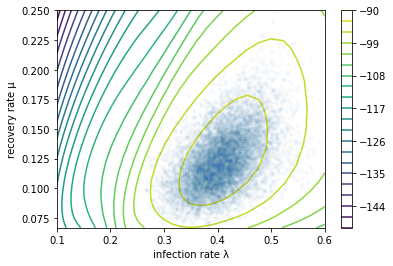

In [19]:
maxi = np.max(logp_mat, axis=(0,3,4))
print(maxi.shape)
fig, ax  = plt.subplots(1)
cntr1 = ax.contour(np.exp(lambda_r), np.exp(mu_r),maxi.T, levels=20)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.set_xlabel('infection rate λ')
ax.set_ylabel('recovery rate μ')
ax.plot(trace.λ, trace.μ, '.', alpha=0.02)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
fig.colorbar(cntr1, ax=ax)

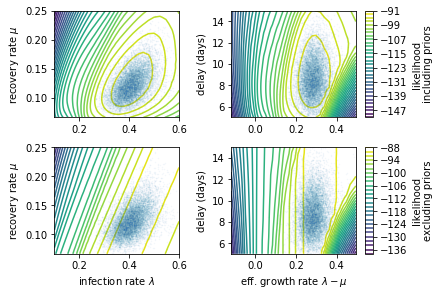

In [62]:
import scipy.ndimage

fig, axes = plt.subplots(2,2, figsize=(6,4), constrained_layout=True)

ax = axes[0,0]
likeli = np.max(logp_mat, axis=(0,3,4))
max_likeli_int = round(np.ceil(np.max(likeli)))

cntr1 = ax.contour(np.exp(lambda_r), np.exp(mu_r),likeli.T, 
                   levels=np.arange(max_likeli_int-60, max_likeli_int+1, 2))
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.set_ylabel('recovery rate $\mu$')
ax.plot(trace.λ, trace.μ, '.', alpha=0.05, ms=3, mew=0)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax = axes[0][1]
mat_lambda_mu = np.exp(lambda_r[:, None]) - np.exp(mu_r[None,:])
sort = np.argsort(mat_lambda_mu, axis=None)
eff_lambda = np.sort(mat_lambda_mu, axis=None)
likeli = np.max(logp_mat.reshape(logp_mat.shape[0], -1, *logp_mat.shape[-2:])[:,sort], axis=(0,3))
#likeli = scipy.ndimage.maximum_filter(likeli, size=(40,1))
likeli = np.max(likeli.reshape(40, 30, 30), axis=1)
max_likeli_int = round(np.ceil(np.max(likeli)))
cntr2 = ax.contour(eff_lambda[15::30], np.exp(delay_r),likeli.T, 
                   levels=np.arange(max_likeli_int-60, max_likeli_int+1, 2))
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.set_ylabel('delay (days)')
ax.plot(trace.λ- trace.μ, trace.delay, '.', mew=0, ms=3, alpha=0.05)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
cbar = fig.colorbar(cntr2, ax=ax)
cbar.set_label('likelihood\nincluding priors')

ax = axes[1][0]

likeli = np.max(logp_flat_mat, axis=(0,3,4))
max_likeli_int = round(np.ceil(np.max(likeli)))

cntr1 = ax.contour(np.exp(lambda_r), np.exp(mu_r),likeli.T, 
                   levels=np.arange(max_likeli_int-50, max_likeli_int+2, 2))
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.set_xlabel('infection rate $\lambda$')
ax.set_ylabel('recovery rate $\mu$')
ax.plot(trace.λ, trace.μ, '.',  mew=0, ms=3, alpha=0.05)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax = axes[1][1]


mat_lambda_mu = np.exp(lambda_r[:, None]) - np.exp(mu_r[None,:])
sort = np.argsort(mat_lambda_mu, axis=None)
eff_lambda = np.sort(mat_lambda_mu, axis=None)
likeli = np.max(logp_flat_mat.reshape(logp_mat.shape[0], -1, *logp_mat.shape[-2:])[:,sort], axis=(0,3))
#likeli = scipy.ndimage.maximum_filter(likeli, size=(40,1))
likeli = np.max(likeli.reshape(40, 30, 30), axis=1)
max_likeli_int = round(np.ceil(np.max(likeli)))
cntr4 = ax.contour(eff_lambda[15::30], np.exp(delay_r),likeli.T, 
                   levels=np.arange(max_likeli_int-50, max_likeli_int+2, 2))
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.set_xlabel('eff. growth rate $\lambda - \mu$')
ax.set_ylabel('delay (days)')
ax.plot(trace.λ- trace.μ, trace.delay, '.', mew=0, ms=3, alpha=0.05)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
cbar = fig.colorbar(cntr4, ax=ax)
cbar.set_label('likelihood\nexcluding priors')

path_to_save = '../../figures/'
plt.savefig(path_to_save + 'Fig_brute_force_contours.png', dpi = 300)
plt.savefig(path_to_save + 'Fig_brute_force_contours.svg')



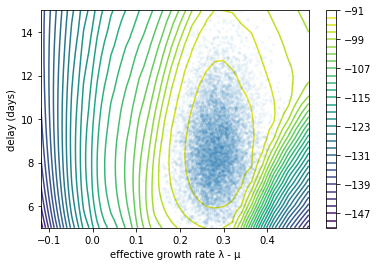

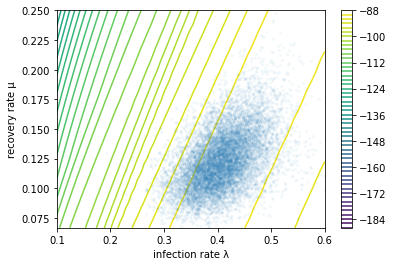

In [15]:
likeli = np.max(logp_flat_mat, axis=(0,3,4))
fig, ax  = plt.subplots(1)
max_likeli_int = round(np.ceil(np.max(likeli)))

cntr1 = ax.contour(np.exp(lambda_r), np.exp(mu_r),likeli.T, 
                   levels=np.arange(max_likeli_int-100, max_likeli_int+2, 2))
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.set_xlabel('infection rate λ')
ax.set_ylabel('recovery rate μ')
ax.plot(trace.λ, trace.μ, '.', mew=0, alpha=0.05)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
fig.colorbar(cntr1, ax=ax)

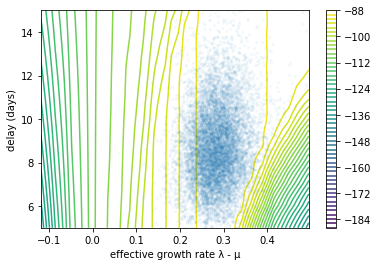

In [17]:
import scipy.ndimage

mat_lambda_mu = np.exp(lambda_r[:, None]) - np.exp(mu_r[None,:])
sort = np.argsort(mat_lambda_mu, axis=None)
eff_lambda = np.sort(mat_lambda_mu, axis=None)
likeli = np.max(logp_flat_mat.reshape(logp_mat.shape[0], -1, *logp_mat.shape[-2:])[:,sort], axis=(0,3))
#likeli = scipy.ndimage.maximum_filter(likeli, size=(40,1))
likeli = np.max(likeli.reshape(40, 30, 30), axis=1)
fig, ax  = plt.subplots(1)
max_likeli_int = round(np.ceil(np.max(likeli)))
cntr1 = ax.contour(eff_lambda[15::30], np.exp(delay_r),likeli.T, 
                   levels=np.arange(max_likeli_int-100, max_likeli_int+2, 2))
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.set_xlabel('effective growth rate λ - μ')
ax.set_ylabel('delay (days)')
ax.plot(trace.λ- trace.μ, trace.delay, '.', mew=0, alpha=0.05)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
fig.colorbar(cntr1, ax=ax)